In [1]:
from methods.utils import *

In [2]:
with open('first_database.pkl', 'rb') as f:
    x, y = pickle.load(f)

# Parameters

In [ ]:
n, m, a = 100, 10, 5
sigma2 = 0.25
nu = 1
beta = 1
n_epochs = 10000
sigma = 0.5
step_size = 0.01

In [24]:
x_n = x[:n] 
y_n = y[:n]
sel = [i for i in range(n)]
ind = np.random.choice(sel, m, replace=False)
x_selected = np.array([x[i] for i in ind])
Kmm = compute_kernel_matrix(x_selected, x_selected)
Knm = compute_kernel_matrix(x_n, x_selected)
alpha_star = compute_alpha_star(Kmm, Knm, y_n, sigma2, nu)
#W = np.ones((a, a))
#W = W_base(a)
W = W_base_bis(a)
# W = fully_connected_graph(a)
#W = linear_graph(a)
#W = small_world_graph(a)
K = compute_kernel_matrix(x_n, x_n)
N = np.arange(n)
np.random.shuffle(N)
A = np.array_split(N, a)

# Methods

In [5]:
def DGD(X, Y, X_selected, A, nu, sigma2, alpha_star, W, step_size, n_epochs=500):
    """
    Decentralized Gradient Descent (DGD) optimisé.
    """
    m = X_selected.shape[0]
    a = len(A)
    
    # Initialization of alpha
    alpha = np.zeros((a * m, 1))
    
    #Normalized Weight Matrix
    W_bar = np.kron(W / 3, np.eye(m))
        
    optimal_gaps = [[] for _ in range(a)]
    alpha_list_agent = []
    alpha_mean_list = []
    
    for _ in range(n_epochs):
        grad = grad_alpha(sigma2, nu, Y, X, X_selected, alpha, A, m)
        alpha = W_bar @ alpha - step_size * grad.reshape(a * m, 1)
        alpha_list_agent.append(alpha.reshape(a, m))
        alpha_mean_list.append(alpha.reshape(a, m).mean(axis=0))
        for agent_idx in range(a):
            optimal_gaps[agent_idx].append(np.linalg.norm(alpha.reshape(a, m)[agent_idx] - alpha_star))
    
    alpha_optim = alpha.reshape(a, m).mean(axis=0)
    
    return optimal_gaps, alpha_optim, alpha_list_agent, alpha_mean_list

In [6]:
def gradient_tracking(x, y, x_selected, A, nu, sigma2, alpha_star, W, lr, n_epochs = 500):
    """
    Implement the GT algorithm
    """
    a = len(A)
    m = x_selected.shape[0]
    alpha = np.zeros((a * m, 1))        # local parameters of the agents
    g = np.zeros((a * m, 1))            # gradient tracking term (a*m, 1)
    W_bar = np.kron(W, np.eye(m))   # Consensus matrix


    optimal_gaps = [[] for _ in range(a)]
    alpha_list_agent = []
    alpha_mean_list = []

    # initialization of the gradient
    grad_old = grad_alpha(sigma2, nu, y, x, x_selected, alpha, A, m).reshape((a * m, 1))  # (a, m)
    g = grad_old.copy()

    for epoch in range(n_epochs):
        # update alpha_i using g
        alpha = W_bar @ alpha - lr * g

        grad_new = grad_alpha(sigma2, nu, y, x, x_selected, alpha, A, m).reshape((a * m, 1))  # (a, m)

        # update g^i
        g = (W_bar @ g + (grad_new - grad_old))

        grad_old = grad_new
    
        alpha_list_agent.append(alpha.reshape(a, m))
        alpha_mean_list.append(alpha.reshape(a, m).mean(axis=0))

        for agent in range(a):
            optimal_gaps[agent].append(np.linalg.norm(alpha.reshape(a, m)[agent] - alpha_star))

    alpha_optim = alpha.reshape(a, m).mean(axis=0)

    return optimal_gaps, alpha_optim, alpha_list_agent, alpha_mean_list

In [7]:

def ADMM(X, Y, X_selected, A, nu, sigma2, n_epochs, W, beta):
    """
    ADMM Implementation
    """
    a = len(A)  
    m = len(X_selected)  # Number of selected points

    # Define neighbors for each agent based on the adjacency matrix
    neighbors = [[j for j in range(a) if j != i and W[i, j] > 0.0001] for i in range(a)]

    # Compute kernel matrices
    Kmm = compute_kernel_matrix(X_selected, X_selected)
    KimKim = [compute_kernel_matrix(X[A[i]], X_selected).T @ 
              compute_kernel_matrix(X[A[i]], X_selected) for i in range(a)]
    yKnm = [compute_kernel_matrix(X[A[i]], X_selected).T @ Y[A[i]] for i in range(a)]

    # Initialize dual variables and auxiliary variables
    lambda_k = {}  # Lagrange multipliers
    y_k = {}  # Auxiliary variables for consensus

    for i in range(a):
        for j in neighbors[i]:
            lambda_k[i, j] = np.zeros(m)  # Initialize Lagrange multipliers
            if i < j:
                s = np.random.rand(m) 
                y_k[i, j] = s
                y_k[j, i] = s  

    iteration = 0
    deviation_alpha_star = []  # Track deviation from the optimal alpha_star
    alpha_list = []
    alpha_mean_list = []

    # Compute the reference optimal solution alpha_star
    Knm = compute_kernel_matrix(X, X_selected)
    alpha_star = compute_alpha_star(Kmm, Knm, Y, sigma2, nu)

    while iteration <= n_epochs:
        iteration += 1

        alpha_k = [
            np.linalg.solve(
                (nu / a) * np.identity(m) +
                (sigma2 / a) * Kmm +
                KimKim[i] +
                sum(beta * np.identity(m) for j in neighbors[i]),  # Adjust for neighbors

                yKnm[i] + sum(beta * y_k[i, j] - lambda_k[i, j] for j in neighbors[i])
            )
            for i in range(a)
        ]
        alpha_k = np.array(alpha_k)  # Convert to NumPy array

        # Store alpha values for tracking
        alpha_list.append(alpha_k.copy())  
        alpha_mean_list.append(np.mean(alpha_k, axis=0))  # Compute mean alpha

        # Compute deviation from alpha_star
        deviation_alpha_star.append([np.linalg.norm(alpha_k[i] - alpha_star) for i in range(a)])

        # Update auxiliary variables y_k and Lagrange multipliers lambda_k
        for i in range(a):
            for j in neighbors[i]:
                y_k[i, j] = 0.5 * (alpha_k[i] + alpha_k[j])  # Average of neighbor alphas
                lambda_k[i, j] += beta * (alpha_k[i] - y_k[i, j])  # Update Lagrange multipliers

    return alpha_k, alpha_list, alpha_mean_list, np.array(deviation_alpha_star)

In [8]:
def solve_alpha(x, y, x_selected, A, sigma, nu, adj_matrix, lamb):
    """
    Computes the alpha values for a dual decomposition approach in a distributed kernel-based method."
    """

    n_samples = len(x)
    a = len(A)
    m = len(x_selected)
    
    Kmm = compute_kernel_matrix(x_selected, x_selected)
    # Initialize list to store alpha values for each agent
    alpha_values = []

    for agent in range(a):
        Kim = compute_kernel_matrix(x[A[agent]], x_selected)
        # Construct the system matrix A using kernel properties and regularization
        A_matrix = sigma**2 * Kmm + np.eye(m) * nu + Kim.T @ Kim
        b_vector = Kim.T @ y[A[agent]] # Compute the right-hand side vector b

        # Adjust b_vector based on Lagrange multipliers from neighboring agents
        for neighbor_idx in range(a):
            if adj_matrix[agent, neighbor_idx] != 0:
                if agent > neighbor_idx:
                    b_vector -= lamb[agent, neighbor_idx, :]
                else:
                    b_vector += lamb[neighbor_idx, agent, :]

        # Solve the linear system A * alpha = b
        alpha_values.append(np.linalg.solve(A_matrix, b_vector))

    return np.array(alpha_values)

def dualDec(x, y, selected_points, A, K, sigma, nu, step_size, W, max_iter=1000, lamb0=0):
    """
    Performs dual decomposition for distributed kernel-based learning."
    """
    # Construct the communication graph (binary adjacency matrix)
    communication_graph = (W > 0).astype(int)
    
    m = len(selected_points)
    a = len(A)
    
    # Ensure diagonal of graph is zero (no self-connections)
    for agent in range(a):
        communication_graph[agent, agent] = 0

    # Initialize Lagrange multipliers
    lambda_ij = lamb0 * np.ones((a, a, m))

    # Lists to track alpha values across iterations
    alpha_mean_list = []
    alpha_list_agent = []

    for _ in tqdm(range(max_iter)):
        # Compute optimal alpha values for each agent
        alpha_optim = solve_alpha(
            x, y, selected_points, A, sigma, nu, 
            communication_graph, lambda_ij
        )

        # Update Lagrange multipliers for connected agents
        for agent_i in range(a):
            for agent_j in range(agent_i):  # Only update for i > j
                lambda_ij[agent_i, agent_j, :] += step_size * (alpha_optim[agent_i, :] - alpha_optim[agent_j, :])

        # Track mean alpha values and per-agent alphas over iterations
        alpha_mean_list.append(alpha_optim.mean(axis=0))
        alpha_list_agent.append(alpha_optim)

    # Compute the final optimized alpha as the mean across agents
    alpha_optim = np.mean(alpha_optim.reshape(a, m), axis=0)

    return alpha_optim, alpha_list_agent, alpha_mean_list

In [9]:
alpha_optimal = compute_alpha_star(Kmm, Knm, y_n, sigma2, nu)

In [10]:
alpha_optim_admm, alpha_list_admm, alpha_mean_list_admm, opt_gaps_admm = ADMM(x_n, y_n, x_selected, A, nu, sigma2, n_epochs, W, beta)

In [ ]:
alpha_optim_dgd, opt_gaps_dgd, alpha_list_dgd, alpha_mean_list_dgd = DGD(x_n, y_n, x_selected, A, nu, sigma2, alpha_star, W, step_size, n_epochs)

In [ ]:
alpha_optim_gt, opt_gaps_gt, alpha_list_gt, alpha_mean_list_gt = gradient_tracking(x_n, y_n, x_selected, A, nu, sigma2, alpha_star, W, step_size, n_epochs)

In [21]:
alpha_optim_dd, alpha_list_dd, alpha_mean_list_dd = dualDec(
        x_n, y_n, x_selected, A,
        K, sigma, nu, 0.1, W, max_iter=10000, lamb0=0.
    )

100%|██████████| 10000/10000 [00:51<00:00, 194.04it/s]


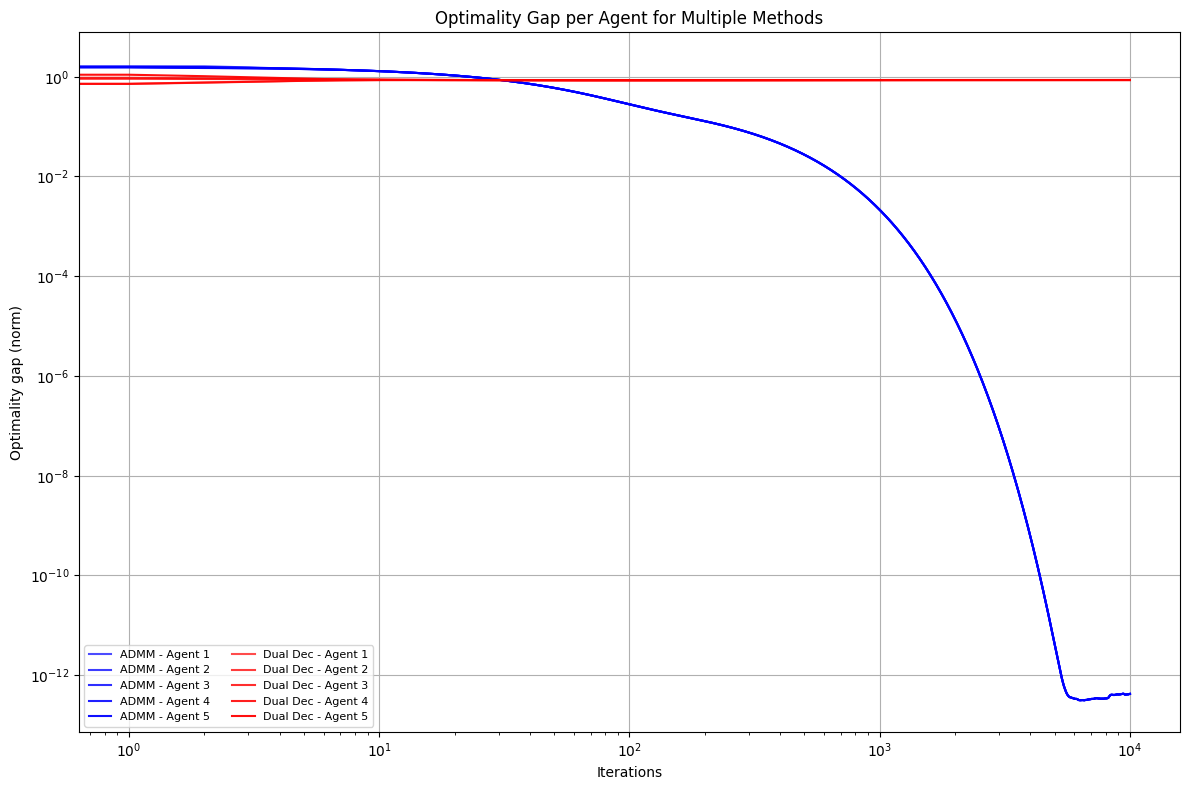

In [22]:
plot_multi_method([alpha_list_admm, alpha_list_dd], alpha_star, method_names=['ADMM', 'Dual Dec'])

In [33]:
# different n 
n_list = [100,500,1000, 2000, 10000]
alphas_n_admm = []
alphas_n_dgd = []
alphas_n_gt = []
alphas_n_dd = []

for n in n_list:
    print(f"n = {n}")
    m = int(np.sqrt(n))  # Number of selected points
    a = 5
    n_epochs = 10000
    
    x_n = x[:n] 
    y_n = y[:n]
    sel = [i for i in range(n)]
    ind = np.random.choice(sel, m, replace=False)
    x_selected = np.array([x[i] for i in ind])
    Kmm = compute_kernel_matrix(x_selected, x_selected)
    Knm = compute_kernel_matrix(x_n, x_selected)
    alpha_star = compute_alpha_star(Kmm, Knm, y_n, sigma2, nu)
    #W = np.ones((a, a))
    #W = W_base(a)
    # W = W_base_bis(a)
    W = fully_connected_graph(a)
    #W = linear_graph(a)
    #W = small_world_graph(a)
    K = compute_kernel_matrix(x_n, x_n)
    N = np.arange(n)
    np.random.shuffle(N)
    A = np.array_split(N, a)
    
    alpha_optim_admm, alpha_list_admm, alpha_mean_list_admm, opt_gaps_admm = ADMM(x_n, y_n, x_selected, A, nu, sigma2, n_epochs, W, beta)
    alphas_n_admm.append(alpha_optim_admm)

    alpha_optim_dgd, opt_gaps_dgd, alpha_list_dgd, alpha_mean_list_dgd = DGD(x_n, y_n, x_selected, A, nu, sigma2, alpha_star, W, step_size, n_epochs)
    alphas_n_dgd.append(alpha_optim_dgd)
    
    alpha_optim_gt, opt_gaps_gt, alpha_list_gt, alpha_mean_list_gt = gradient_tracking(x_n, y_n, x_selected, A, nu, sigma2, alpha_star, W, step_size, n_epochs)
    alphas_n_gt.append(alpha_optim_gt)

    alpha_optim_dd, alpha_list_dd, alpha_mean_list_dd = dualDec(x_n,y_n,x_selected,A,K,sigma2 ,nu ,0.1,W,max_iter=1000)
    alphas_n_dd.append(alpha_optim_dd)


n = 100


100%|██████████| 1000/1000 [00:09<00:00, 106.61it/s]


n = 500


c:\Users\AHMED-YASSINE\Desktop\COURS ENSTA\3A\CODS\Cooperative-Opt-project\methods\utils.py:59: RuntimeWarning: overflow encountered in matmul
  Kmm = compute_kernel_matrix(X_selected, X_selected)
c:\Users\AHMED-YASSINE\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:118: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
C:\Users\AHMED-YASSINE\AppData\Local\Temp\ipykernel_16664\385034623.py:20: RuntimeWarning: invalid value encountered in matmul
  alpha = W_bar @ alpha - step_size * grad.reshape(a * m, 1)
c:\Users\AHMED-YASSINE\Desktop\COURS ENSTA\3A\CODS\Cooperative-Opt-project\methods\utils.py:59: RuntimeWarning: overflow encountered in add
  Kmm = compute_kernel_matrix(X_selected, X_selected)
C:\Users\AHMED-YASSINE\AppData\Local\Temp\ipykernel_16664\3840554700.py:27: RuntimeWarning: overflow encountered in subtract
  g = (W_bar @ g + (grad_new - grad_old))
C:\Users\AHMED-YASSINE\AppData\

n = 1000


KeyboardInterrupt: 

In [ ]:
n_list = [100,500,1000, 2000, 10000]
alpha_star_n = []

for i, n in enumerate(n_list):
    print(f"n = {n}")
    m = int(np.sqrt(n))  # Number of selected points
    a = 5
    n_epochs = 10000
    
    x_n = x[:n] 
    y_n = y[:n]
    sel = [i for i in range(n)]
    ind = np.random.choice(sel, m, replace=False)
    x_selected = np.array([x[i] for i in ind])
    Kmm = compute_kernel_matrix(x_selected, x_selected)
    Knm = compute_kernel_matrix(x_n, x_selected)
    alpha_star = compute_alpha_star(Kmm, Knm, y_n, sigma2, nu)
    #W = np.ones((a, a))
    #W = W_base(a)
    # W = W_base_bis(a)
    W = fully_connected_graph(a)
    #W = linear_graph(a)
    #W = small_world_graph(a)
    K = compute_kernel_matrix(x_n, x_n)
    N = np.arange(n)
    np.random.shuffle(N)
    A = np.array_split(N, a)
    alpha_star_n.append(alpha_star)

    

n = 100
n = 500
n = 1000
n = 2000
n = 10000


KeyboardInterrupt: 

In [34]:
len(alphas_n_dgd)

2

In [35]:
## DGD with respect to n
n_list = [100,500]
plt.figure(figsize=(10, 6))
# plot the optimal gap for DGD with respect to n
plt.plot(n_list, [np.linalg.norm(alphas_n_dgd[i] - alpha_star_n[i]) for i in range(len(n_list))], label='DGD', marker='o')
plt.legend()
plt.xlabel('Iterations')
plt.ylabel('Optimal gap')
plt.title('DGD with respect to n')
plt.grid()
plt.tight_layout()
plt


ValueError: operands could not be broadcast together with shapes (5,10000) (10,) 

<Figure size 1000x600 with 0 Axes>